In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [2]:
print(tf.test.is_built_with_cuda())
print(tf.executing_eagerly())
tf.config.list_physical_devices('GPU')

True
True


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
batch_size = 5
img_height = 1500
img_width = 1500

In [4]:
data_dir = "archive/tiff/"
print(os.listdir(data_dir))

['test', 'test_labels', 'train', 'train_labels', 'val', 'val_labels']


In [5]:
bmp = "archive/bmp/"
folders = os.listdir(bmp)
filenames =  [[],[],[],[],[],[]]
i=0
for folder in folders:
    images = os.listdir(bmp + folder)
    for image in images:
        filenames[i].append(str(bmp + folder + "/" + image))
    i += 1
test, test_labels, train, train_labels, val, val_labels = filenames

In [6]:
def read_filenames(filepath1, filepath2):
    pil_image1 =  tf.io.read_file(filepath1)
    image1 = tf.io.decode_bmp(pil_image1, channels=0)
    pil_image2 =  tf.io.read_file(filepath2)
    image2 = tf.io.decode_bmp(pil_image2, channels=0)
    return (image1,image2)

In [7]:
class DataReader():
    def __init__(self, filenames1, filenames2, batch_size):
        # filenames: list of files
        self.filenames1 = filenames1
        self.filenames2 = filenames2
        self.dataset = None
        print("{} filenames received".format(len(filenames1)))
        print("{} filenames received".format(len(filenames2)))
        self.batch_size = batch_size
        self.run()
        
    def read_filenames(self, filepath1, filepath2):
        pil_image1 =  tf.io.read_file(filepath1)
        image1 = tf.io.decode_bmp(pil_image1, channels=0)
        image1 = tf.image.resize(image1, [500,500])
        image1 = tf.cast(image1, tf.float32)
        image1 = image1/255.
        pil_image2 =  tf.io.read_file(filepath2)
        image2 = tf.io.decode_bmp(pil_image2, channels=0)
        image2 = tf.image.resize(image2, [500,500])
        image2 = tf.keras.backend.flatten(image2)
        image2 = tf.cast(image2, tf.int32)
        image2 = image2/255
        return [image1,image2]

    def run(self):
        self.dataset = tf.data.Dataset.from_tensor_slices((self.filenames1, self.filenames2))
        self.dataset = self.dataset.shuffle(len(self.filenames1), reshuffle_each_iteration=True)
        self.dataset = self.dataset.map(self.read_filenames, num_parallel_calls=10)
        self.dataset = self.dataset.batch(self.batch_size)
#         self.dataset = self.dataset.prefetch(1)
        return self.dataset

In [8]:
# dataset = tf.data.Dataset.from_tensor_slices((test, test_labels))
# # print(list(dataset.take(3).as_numpy_iterator()))
# dataset = dataset.shuffle(3, reshuffle_each_iteration=True)
# dataset = dataset.map(read_filenames, num_parallel_calls=10)
# dataset = dataset.batch(batch_size)
# dataset = dataset.prefetch(1)
# print(list(dataset.take(3).as_numpy_iterator()))

In [9]:
test_data = DataReader(test, test_labels, batch_size)
# print(list(test_data.dataset.take(1).as_numpy_iterator())[0].shape)
# test_labels_data = DataReader(test_labels, batch_size)
train_data = DataReader(train,train_labels, batch_size)
# train_labels_data = DataReader(train_labels, batch_size)
val_data = DataReader(val,val_labels, batch_size)
# val_labels_data = DataReader(val_labels, batch_size)

49 filenames received
49 filenames received
1108 filenames received
1108 filenames received
14 filenames received
14 filenames received


## Show some images

(5, 500, 500, 3)


IndexError: index 5 is out of bounds for axis 0 with size 5

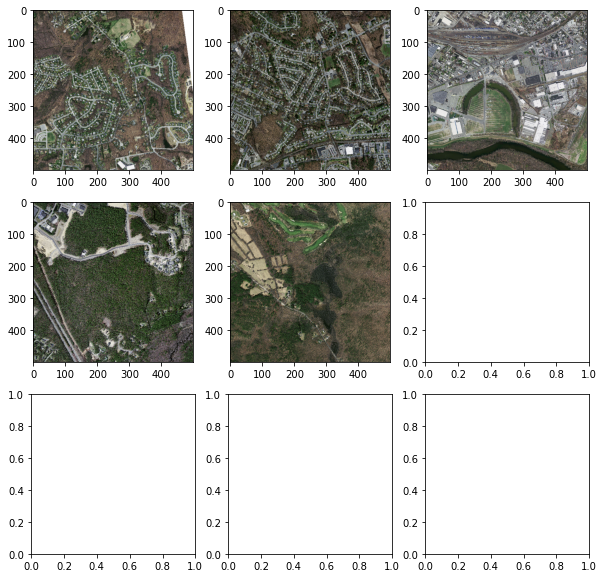

In [10]:
# Test data
fig, axs = plt.subplots(3, 3)
fig.set_figheight(10)
fig.set_figwidth(10)
x = list(test_data.dataset.take(9).as_numpy_iterator())[0][:9]
print(x[0].shape)
index = 0
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(x[0][index,:,:,:])
        index += 1

In [ ]:
# Test Labels data
fig, axs = plt.subplots(3, 3)
fig.set_figheight(10)
fig.set_figwidth(10)
x = list(test_data.dataset.take(9).as_numpy_iterator())[0][:9]
index = 0
for i in range(3):
    for j in range(3):
        axs[i][j].imshow(x[index])
        index += 1

## Inspection of the shape of our data

In [11]:
print("Input data = {}".format(list(test_data.dataset.take(1).as_numpy_iterator())[0][0].shape))
print("Output data = {}".format(list(test_data.dataset.take(1).as_numpy_iterator())[0][1].shape))

Input data = (5, 500, 500, 3)
Output data = (5, 250000)


In [12]:
## Check to see that the data is one hot encoded

In [13]:
x = list(test_data.dataset.take(1).as_numpy_iterator())[0][1]
print(x.shape)
np.unique(x, return_counts=True)

(5, 250000)


(array([0., 1.]), array([1176134,   73866], dtype=int64))

# Model Creation (Figure out how to set the final output: 2 classes or 1000x1000 ?)

In [14]:
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec, Layer
class Argmax(Layer):
    """
    Based on https://github.com/YerevaNN/R-NET-in-Keras/blob/master/layers/Argmax.py
    """
    def __init__(self, axis=-1, units=32, **kwargs):
        super(Argmax, self).__init__(trainable=False, **kwargs)
        self.supports_masking = True
        self.axis = axis
        self.units = units

    def call(self, inputs, mask=None):
#         return tf.cast(K.argmax(inputs, axis=self.axis), tf.float32)
        return tf.keras.activations.relu(tf.keras.backend.sign(inputs))

    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        del input_shape[self.axis]
        return tuple(input_shape)

    def compute_mask(self, x, mask):
        return None
    
#     def build(self, input_shape):
#         w_init = tf.random_normal_initializer()
#         self.w = tf.Variable(initial_value=w_init(shape=(input_shape[-1], self.units),
#                              dtype='float32'),trainable=False)

    def get_config(self):
        config = {'axis': self.axis}
        base_config = super(Argmax, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(500,500,3), classes=2)
model = tf.keras.Sequential([ resnet,
        tf.keras.layers.Conv2D(1000, 5, padding='same'),
        tf.keras.layers.Conv2D(512, 5),
        tf.keras.layers.Conv2D(256, 3),
#         tf.keras.layers.Conv2D(100, 5),
#         tf.keras.layers.Conv2D(50, 5),
#         tf.keras.layers.Conv2D(30, 5),
#         tf.keras.layers.Conv2D(15, 3),                     
        tf.keras.layers.Dense(2500),
        tf.keras.layers.Flatten(),
        Argmax()
                            ])
model.summary()

In [31]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(1000, 5,input_shape=(500,500,3), padding='same'),
        tf.keras.layers.Conv2D(512, 2),
        tf.keras.layers.Conv2D(256, 2),
        tf.keras.layers.Conv2D(100, 5),
        tf.keras.layers.Conv2D(50, 5),
        tf.keras.layers.Conv2D(1, 5),
        tf.keras.layers.Conv2D(1, 5),                     
        tf.keras.layers.Dense(2500),
        tf.keras.layers.Flatten(),
        Argmax()
                            ])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 500, 500, 1000)    76000     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 499, 499, 512)     2048512   
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 498, 498, 256)     524544    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 494, 494, 100)     640100    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 490, 490, 50)      125050    
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 486, 486, 1)       1251      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 482, 482, 1)      

In [16]:
model.summary()
500*500

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 16, 16, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 1000)      51201000  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 512)       12800512  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       1179904   
_________________________________________________________________
dense (Dense)                (None, 10, 10, 2500)      642500    
_________________________________________________________________
flatten (Flatten)            (None, 250000)            0         
_________________________________________________________________
argmax (Argmax)              (None, 250000)            0

250000

In [17]:
for l in model.layers:
    print(l.name, l.trainable)

resnet50 True
conv2d True
conv2d_1 True
conv2d_2 True
dense True
flatten True
argmax False


In [18]:
def myLoss(y_true, y_pred):
# #     flatten = tf.keras.backend.flatten(y_pred)
#     reshaped = tf.keras.backend.reshape(y_pred, (-1,2))
#     argmax = tf.cast(tf.keras.backend.argmax(y_pred), tf.int32)
#     print(y_true)
#     print(argmax)
    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return loss
    
# loss_fn = tf.keras.losses.MeanSquaredError()


In [19]:
model.compile(optimizer='adam',
              loss=myLoss,
              metrics=['accuracy'])

In [20]:
# for layer in model.layers:
#     layer.add_loss(losses=tf.keras.losses.MeanSquaredError())

In [21]:
model.fit(train_data.dataset, verbose=1, epochs=1)

222/222 [==============================] - 134s 602ms/step - loss: 0.4982 - accuracy: 0.0235


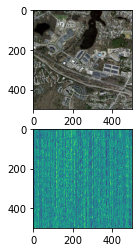

In [23]:
fig, axs = plt.subplots(2)
test_result = model.predict(tuple(train_data.dataset.take(1))[0][0][:1]).reshape((500,500))
axs[0].imshow(tuple(train_data.dataset.take(1))[0][0][1])
axs[1].imshow(test_result)
# tuple(train_data.dataset.take(1))[0][0][1].numpy()

In [24]:
# Result data
np.unique(model(tuple(train_data.dataset.take(1))[0][0][:1]).numpy(), return_counts=True)

(array([0., 1.], dtype=float32), array([126162, 123838], dtype=int64))

In [25]:
np.unique((tuple(train_data.dataset.take(1))[0][1][:1]).numpy(), return_counts=True)

(array([0., 1.]), array([234999,  15001], dtype=int64))

In [26]:
# Image.fromarray(test_result)
# im.save('test.jpg')
# plt.savefig(test_result)
cv2.imread(test_result)

SystemError: <built-in function imread> returned NULL without setting an error